In [4]:
import os
import sys

import ase.collections
import numpy as np
import copy
import yaml

import argparse

import ase.build
import ase.optimize
import ase.io.trajectory
import ase.visualize
import ase.vibrations
import logging

import fairchem.core.models.model_registry
import fairchem.core.common.relaxation.ase_utils

import matplotlib.pyplot as plt

# sys.path.append(os.environ['SURFACE_THERMO_DIR'])
sys.path.append('/home/moon/surface/surface_thermo')
import util

In [2]:
os.environ['SURFACE_THERMO_DIR'] = '/home/moon/surface/surface_thermo'

In [6]:
slab_file = '/home/moon/surface_thermo/results/slab/Cr_bcc110_slab.traj'
slab_file = '/home/moon/surface/surface_thermo/results/slab/Fe_fcc111_slab.traj'
# slab_file = '/home/moon/surface_thermo/results/slab/Cr2O3_z_slab.traj'

traj = ase.io.trajectory.Trajectory(slab_file)
slab = traj[-1]

In [8]:
# local_cache = os.environ['FAIRCHEM_LOCAL_CACHE']
checkpoint_path = fairchem.core.models.model_registry.model_name_to_local_file(
    'GemNet-OC-S2EFS-nsn-OC20+OC22',
    # 'EquiformerV2-31M-S2EF-OC20-All+MD',
    local_cache='/home/moon/surface/tmp/fairchem_checkpoints/'
    # local_cache=local_cache
)
calc = fairchem.core.common.relaxation.ase_utils.OCPCalculator(
    checkpoint_path=checkpoint_path,
    cpu=True,
    seed=400
)


/home/moon/surface/fairchem_env/lib/python3.12/site-packages/fairchem/core/models/escn/so3.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd = torch.load(os.path.join

# mess with this until the position looks about right

In [16]:
slab.info

{'adsorbate_info': {'cell': array([[2.43421509, 0.        ],
         [1.21710755, 2.10809211]]),
  'sites': {'ontop': [0, 0],
   'bridge': [0.5, 0],
   'fcc': [0.3333333333333333, 0.3333333333333333],
   'hcp': [0.6666666666666666, 0.6666666666666666]}}}

Atoms(symbols='Fe36', pbc=[True, True, False], cell=[[7.30264528270407, 0.0, 0.0], [3.651322641352035, 6.324276329648317, 0.0], [0.0, 0.0, 25.96258490505586]], initial_magmoms=..., tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), calculator=SinglePointCalculator(...))

In [29]:
test_system = copy.deepcopy(slab)

adsorbate_label = 'N'
adsorbate = ase.build.molecule(adsorbate_label)


# trying to absorb N into bulk
# site = (1.1, 0.5)
height = 2.0

# multiplier = np.array(slab.info['adsorbate_info']['sites']['hcp']) * 3.4424999999999999
site = np.array(slab.info['adsorbate_info']['sites']['fcc']) * 3.4424999999999999

ase.build.add_adsorbate(test_system, adsorbate, height=height, position=site)

ase.visualize.view(test_system, viewer='x3d')

# Get the energies at different heights

In [32]:
system = copy.deepcopy(slab)
heights = np.linspace(-5.0, 2.0, 21)
height_energies = np.zeros(len(heights))
test_system = copy.deepcopy(slab)
for i, height in enumerate(heights):
    print(i)
    ase.build.add_adsorbate(test_system, adsorbate, height=height, position=site)
    test_system.calc = calc
    height_energies[i] = test_system.get_potential_energy()
    # remove the adsorbate for the next iteration
    test_system = test_system[:len(slab)]
# best_height = heights[np.argmin(height_energies)]
# print(f"Best height is {best_height:.2f} Å")

# ase.build.add_adsorbate(system, adsorbate, height=height, position=site)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


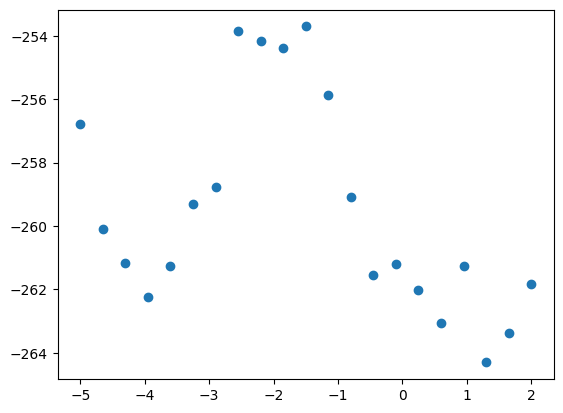

In [33]:
plt.scatter(heights, height_energies)

In [36]:
system = copy.deepcopy(slab)
heights = np.linspace(-5.0, 2.0, 21)
height_energies = np.zeros(len(heights))
test_system = copy.deepcopy(slab)

images = []
for i, height in enumerate(heights):
    print(i)
    ase.build.add_adsorbate(test_system, adsorbate, height=height, position=site)
    test_system.calc = calc
    # height_energies[i] = test_system.get_potential_energy()

    
    system_trajectory_file = f'height_{i}.traj'

    fmax = 0.05
    MAXSTEP = 100
    opt = ase.optimize.BFGS(test_system, trajectory=system_trajectory_file)
    opt.run(fmax=fmax, steps=MAXSTEP)
    height_energies[i] = test_system.get_potential_energy()
    images.append(test_system)

    
    # remove the adsorbate for the next iteration
    test_system = test_system[:len(slab)]


0
      Step     Time          Energy          fmax
BFGS:    0 00:41:54     -256.772003       37.827960
BFGS:    1 00:41:55     -255.521713       37.409223
BFGS:    2 00:41:56     -255.300629       25.075584
BFGS:    3 00:41:57     -255.652954       12.237357
BFGS:    4 00:41:58     -256.666504        7.120909
BFGS:    5 00:41:59     -257.205688       13.351956
BFGS:    6 00:42:00     -256.686981        2.960691
BFGS:    7 00:42:02     -256.743408        2.120261
BFGS:    8 00:42:03     -256.736023        1.450656
BFGS:    9 00:42:04     -256.757202        1.106567
BFGS:   10 00:42:05     -256.786896        0.337804
BFGS:   11 00:42:06     -256.784637        0.083191
BFGS:   12 00:42:07     -256.780182        0.031306
1
      Step     Time          Energy          fmax
BFGS:    0 00:42:08     -260.081238        1.331415
BFGS:    1 00:42:09     -260.134674        1.503055
BFGS:    2 00:42:10     -260.993011        4.644928
BFGS:    3 00:42:11     -261.251617       34.091788
BFGS:    4 0

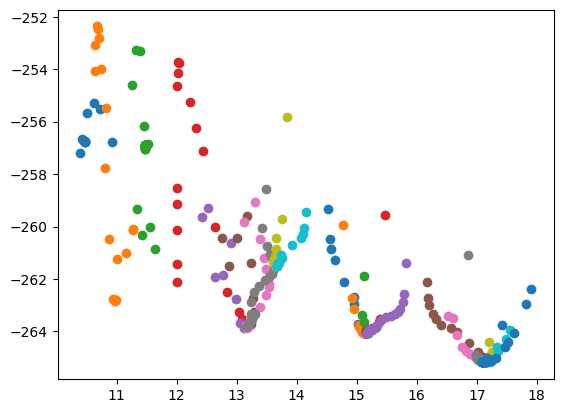

In [47]:

x = []
y = []

for i, height in enumerate(heights):
  
    system_trajectory_file = f'height_{i}.traj'
    traj = ase.io.trajectory.Trajectory(system_trajectory_file)
    heights = np.zeros(len(traj))
    energies = np.zeros(len(traj))
    for j in range(len(traj)):
        heights[j] = traj[j].positions[-1, 2]
        energies[j] = traj[j].calc.results['energy']

        x.append(traj[j].positions[-1, 2])
        y.append(traj[j].calc.results['energy'])
    plt.scatter(heights, energies)    


In [41]:
system = copy.deepcopy(slab)
ase.build.add_adsorbate(system, adsorbate, height=0.0, position=site)
system.positions[-1, 2] = 15.2



In [42]:

ase.visualize.view(system, viewer='x3d')

# Do a more fine-grain investigation

In [43]:
system = copy.deepcopy(slab)
zs = np.linspace(14.5, 17.5, 21)
energies = np.zeros(len(zs))
test_system = copy.deepcopy(slab)

for i, z in enumerate(zs):
    print(i)
    ase.build.add_adsorbate(test_system, adsorbate, height=0, position=site)
    test_system.positions[-1, 2] = z
    test_system.calc = calc

    system_trajectory_file = f'fine_height_{i}.traj'

    fmax = 0.05
    MAXSTEP = 100
    opt = ase.optimize.BFGS(test_system, trajectory=system_trajectory_file)
    opt.run(fmax=fmax, steps=MAXSTEP)

    # remove the adsorbate for the next iteration
    test_system = test_system[:len(slab)]


0
      Step     Time          Energy          fmax
BFGS:    0 01:04:25     -254.399902       41.475540
BFGS:    1 01:04:26     -259.946228       12.589077
BFGS:    2 01:04:27     -261.943573        6.345522
BFGS:    3 01:04:28     -262.590027        3.514595
BFGS:    4 01:04:29     -263.250580        1.433530
BFGS:    5 01:04:30     -263.525024        1.907131
BFGS:    6 01:04:31     -263.690369        1.804957
BFGS:    7 01:04:33     -263.799591        1.347120
BFGS:    8 01:04:34     -263.944794        0.816258
BFGS:    9 01:04:35     -264.053619        0.500591
BFGS:   10 01:04:36     -264.079773        0.345846
BFGS:   11 01:04:37     -264.068787        0.233656
BFGS:   12 01:04:38     -264.048553        0.178126
BFGS:   13 01:04:39     -264.043335        0.116924
BFGS:   14 01:04:40     -264.043976        0.062108
BFGS:   15 01:04:41     -264.034485        0.037662
1
      Step     Time          Energy          fmax
BFGS:    0 01:04:42     -258.944519       19.262181
BFGS:    1 0

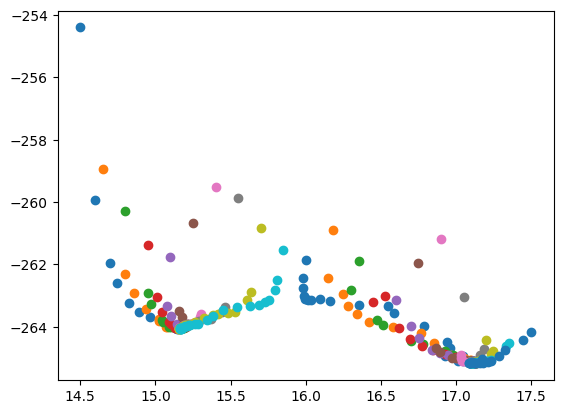

In [48]:
for i, z in enumerate(zs):
  
    system_trajectory_file = f'fine_height_{i}.traj'
    traj = ase.io.trajectory.Trajectory(system_trajectory_file)
    heights = np.zeros(len(traj))
    energies = np.zeros(len(traj))
    for j in range(len(traj)):
        heights[j] = traj[j].positions[-1, 2]
        energies[j] = traj[j].calc.results['energy']

        x.append(traj[j].positions[-1, 2])
        y.append(traj[j].calc.results['energy'])
        
    plt.scatter(heights, energies)    


In [45]:
system = copy.deepcopy(slab)
zs2 = np.linspace(15.7, 16.2, 7)
energies2 = np.zeros(len(zs))
test_system = copy.deepcopy(slab)

for i, z in enumerate(zs2):
    print(i)
    ase.build.add_adsorbate(test_system, adsorbate, height=0, position=site)
    test_system.positions[-1, 2] = z
    test_system.calc = calc

    system_trajectory_file = f'ultra_fine_height_{i}.traj'

    fmax = 0.05
    MAXSTEP = 100
    opt = ase.optimize.BFGS(test_system, trajectory=system_trajectory_file)
    opt.run(fmax=fmax, steps=MAXSTEP)

    # remove the adsorbate for the next iteration
    test_system = test_system[:len(slab)]


0
      Step     Time          Energy          fmax
BFGS:    0 01:18:40     -261.328766       28.982274
BFGS:    1 01:18:41     -259.674225       32.503125
BFGS:    2 01:18:42     -261.779114        8.302503
BFGS:    3 01:18:43     -262.864594        1.781793
BFGS:    4 01:18:44     -263.172455        1.391295
BFGS:    5 01:18:45     -263.450287        1.059885
BFGS:    6 01:18:46     -263.528839        0.835634
BFGS:    7 01:18:47     -263.620178        0.542346
BFGS:    8 01:18:49     -263.724213        0.537790
BFGS:    9 01:18:50     -263.819000        0.484972
BFGS:   10 01:18:51     -263.922363        0.487795
BFGS:   11 01:18:52     -263.976624        0.406449
BFGS:   12 01:18:53     -263.976807        0.209487
BFGS:   13 01:18:54     -263.974335        0.163143
BFGS:   14 01:18:55     -263.966125        0.134313
BFGS:   15 01:18:57     -263.984497        0.116138
BFGS:   16 01:18:58     -264.006348        0.078363
BFGS:   17 01:18:59     -264.014893        0.054575
BFGS:   18 0

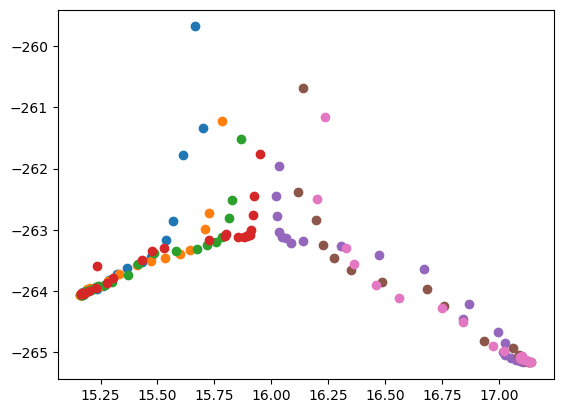

In [49]:


for i, z in enumerate(zs2):
  
    system_trajectory_file = f'ultra_fine_height_{i}.traj'
    traj = ase.io.trajectory.Trajectory(system_trajectory_file)
    heights = np.zeros(len(traj))
    energies = np.zeros(len(traj))
    for j in range(len(traj)):
        heights[j] = traj[j].positions[-1, 2]
        energies[j] = traj[j].calc.results['energy']

        x.append(traj[j].positions[-1, 2])
        y.append(traj[j].calc.results['energy'])
    plt.scatter(heights, energies)    


In [53]:
x

[10.923492717944985,
 10.726937116392023,
 10.623262706160638,
 10.49995601906882,
 10.430459380137709,
 10.393693162393951,
 10.44645566035891,
 10.450799311472403,
 10.460192675415627,
 10.466265595789908,
 10.476591944858091,
 10.476823355017105,
 10.476290814475309,
 11.27919243217003,
 11.268048412293822,
 11.15999971673384,
 11.008075583559574,
 10.828860724727743,
 10.64567926453935,
 10.634963395076687,
 10.675261014554065,
 10.681820732796783,
 10.701288398699768,
 10.741832915437314,
 10.807050352384522,
 10.869185130010752,
 10.931030695774991,
 10.982438778223917,
 10.969729857667355,
 10.968860989461504,
 10.965714752073534,
 10.965247716000398,
 10.965041611375623,
 10.965699659315549,
 10.966428077504576,
 11.633724184299279,
 11.552546186710167,
 11.430512894339826,
 11.340171029329353,
 11.248962419913013,
 11.32086343260879,
 11.390768933869813,
 11.448295235391466,
 11.515629169736895,
 11.47406848569699,
 11.471806743256629,
 11.470853588402704,
 11.468944523651118,

In [76]:
buckets = np.linspace(14.8, 17.5, 31)
buckets[0] = np.nan
indices = np.arange(len(x))
sorted_order = [xx for _, xx in sorted(zip(x, indices))]


# get all things that fall in a bucket
energies = np.zeros_like(buckets) + np.nan
for i in range(1, len(buckets)):
    items = []
    for j in range(len(x)):
        if x[j] < buckets[i] and x[j] > buckets[i - 1]:
            items.append(y[j])
    if items:
        energies[i] = np.min(items)

In [77]:
np.save('zs.npy', x)
np.save('energies.npy', y)

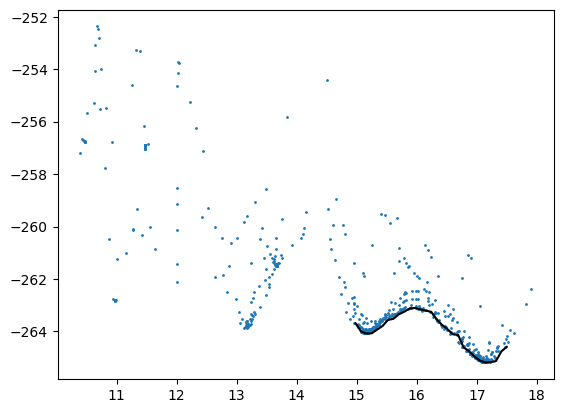

In [78]:
plt.scatter(x, y, s=1.0)
plt.plot(buckets, energies, color='black')

In [79]:
np.nanmax(energies) - np.nanmin(energies)

2.07794189453125

In [104]:
# system_trajectory_file = '/home/moon/surface_thermo/results/system/Cr_bcc110_N2/Cr_bcc110_N2_custom_0.traj'
# system_trajectory_file = '/home/moon/surface_thermo/results/system/Fe_fcc111_N2/Fe_fcc111_N2_custom_0.traj'

system_trajectory_file = '/home/moon/surface_thermo/results/system/Cr2O3_z_N/Cr2O3_z_N_custom_0.traj'
system.calc = calc
fmax = 0.05
MAXSTEP = 100
opt = ase.optimize.BFGS(system, trajectory=system_trajectory_file, append_trajectory=True)
opt.run(fmax=fmax, steps=MAXSTEP)

      Step     Time          Energy          fmax
BFGS:    0 23:32:33    -1864.369385        9.548527
BFGS:    1 23:32:44    -1865.812988        3.059178
BFGS:    2 23:32:55    -1866.156128        1.751973
BFGS:    3 23:33:07    -1866.282227        1.606528
BFGS:    4 23:33:16    -1866.334717        1.706170
BFGS:    5 23:33:26    -1866.679199        1.891906
BFGS:    6 23:33:36    -1866.982422        1.934495
BFGS:    7 23:33:46    -1867.405762        2.253308
BFGS:    8 23:33:56    -1867.892822        2.214406
BFGS:    9 23:34:06    -1868.282837        2.102408
BFGS:   10 23:34:16    -1868.634033        1.673296
BFGS:   11 23:34:26    -1868.802002        1.382930
BFGS:   12 23:34:36    -1868.911743        1.120977
BFGS:   13 23:34:47    -1869.004272        0.929955
BFGS:   14 23:34:56    -1869.156982        0.994823
BFGS:   15 23:35:06    -1869.265015        1.114278
BFGS:   16 23:35:16    -1869.530396        1.109621
BFGS:   17 23:35:26    -1869.801880        1.076852
BFGS:   18 23:

True

In [101]:
ase.visualize.view(system, viewer='x3d')

In [91]:
adsorbate_indices = [i for i in range(len(system)) if i >= len(slab)]

In [92]:
vib_dir = 'custom'
vib = ase.vibrations.Vibrations(system, name=vib_dir, indices=adsorbate_indices)
vib.clean()  # Clean previous results
vib.run()
vib.summary()
freq = vib.get_frequencies()

---------------------
  #    meV     cm^-1
---------------------
  0   18.9     152.6
  1   21.9     176.5
  2   22.6     182.3
  3   27.8     223.8
  4   28.5     230.0
  5  130.9    1056.0
---------------------
Zero-point energy: 0.125 eV


In [93]:
result = {
    'frequencies': freq.tolist(),
    'zpe': float(vib.get_zero_point_energy()),
}

result_file = system_trajectory_file.replace('.traj', '_vib.yaml')
with open(result_file, 'w') as f:
    yaml.dump(result, f, default_flow_style=False)

vib.clean()  # Clean results after the fact
os.rmdir(vib_dir)


In [94]:
# Save a picture of the relaxed system
side_pic = system_trajectory_file.replace('.traj', '_side.png')
top_pic = system_trajectory_file.replace('.traj', '_top.png')
ase.io.write(side_pic, system, rotation='-90x,0y,0z')
ase.io.write(top_pic, system, rotation='0x,0y,0z')


In [77]:
top_pic

'/home/moon/surface_thermo/results/system/Cr_bcc110_N2/Cr_bcc110_N2_custom_0_top.png'